In [1]:
#!pip install --user pyarrow

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from scipy.stats import spearmanr, mannwhitneyu
from scipy.special import expit as sigmoid

tqdm.pandas()

/global/software/sl-7.x86_64/modules/langs/python/3.7/lib/python3.7/site-packages/tqdm/std.py:648: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [3]:
#cis_eQTL = pd.read_csv("~/Downloads/ciseqtl.csv", sep="\t", skiprows=10) # TODO: should also get the trans-eqtl
#cis_eQTL

In [4]:
#df = pd.read_parquet("../mlm/vep.parquet")
#df = df[df.AN >= 2000]
#df = df[(df.AC != 0) & (df.AC != df.AN)]
#df["alt_AF"] = df.AC / df.AN
#df.model_llr = df.apply(lambda row: row.model_llr if row.alt_AF < 0.5 else -row.model_llr, axis=1)
#df["ref_AF"] = 1 - df.alt_AF
#df["alt_AC"] = df.AC
#df["ref_AC"] = df.AN - df.AC
#df["AC"] = df[["ref_AC", "alt_AC"]].min(axis=1)
#df["AF"] = df[["ref_AF", "alt_AF"]].min(axis=1)
#df

In [41]:
#model_name = "window-128_tokenization-no_model-bert"
#model_name = "window-1000_tokenization-bpe8192_model-bert"
model_name = "window-128_tokenization-no_model-convnet"

df = pd.read_parquet(f"vep_full_{model_name}.parquet")
pred_ref_cols = df.columns[df.columns.str.startswith("model_pred_ref_")]
pred_alt_cols = df.columns[df.columns.str.startswith("model_pred_alt_")]
pred_cols = np.concatenate([pred_ref_cols, pred_alt_cols])
df = df[df.AN >= 2000]
df = df[(df.AC != 0) & (df.AC != df.AN)]
#df["AF"] = df.AC / df.AN
#df = df[df.AF < 0.5]
df["alt_AF"] = df.AC / df.AN
df.model_llr = df.apply(lambda row: row.model_llr if row.alt_AF < 0.5 else -row.model_llr, axis=1)
df["ref_AF"] = 1 - df.alt_AF
df["alt_AC"] = df.AC
df["ref_AC"] = df.AN - df.AC
df["AC"] = df[["ref_AC", "alt_AC"]].min(axis=1)
df["AF"] = df[["ref_AF", "alt_AF"]].min(axis=1)
df

,chromosome,pos,ref,alt,AC,AN,closest_TSS,dist_to_TSS,consequence,model_llr,alt_AF,ref_AF,alt_AC,ref_AC,AF
0,Chr5,500,C,T,376,2078,AT5G01010.2,4494,downstream_gene_variant,0.902710,0.180943,0.819057,376,1702,0.180943
1,Chr5,504,T,C,2,2088,AT5G01010.2,4490,intergenic_variant,-0.523748,0.000958,0.999042,2,2086,0.000958
2,Chr5,505,A,G,4,2110,AT5G01010.2,4489,intergenic_variant,-0.758839,0.001896,0.998104,4,2106,0.001896
3,Chr5,510,G,A,6,2122,AT5G01010.2,4484,intergenic_variant,1.105072,0.002828,0.997172,6,2116,0.002828
4,Chr5,512,A,G,2,2126,AT5G01010.2,4482,intergenic_variant,-1.055077,0.000941,0.999059,2,2124,0.000941
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1444080,Chr5,26974897,C,T,6,2074,AT5G67640.1,-4256,intergenic_variant,0.127048,0.002893,0.997107,6,2068,0.002893
1444081,Chr5,26974907,G,A,2,2050,AT5G67640.1,-4266,intergenic_variant,0.811651,0.000976,0.999024,2,2048,0.000976
1444082,Chr5,26974913,C,T,6,2042,AT5G67640.1,-4272,intergenic_variant,0.339191,0.002938,0.997062,6,2036,0.002938
1444083,Chr5,26974918,C,T,4,2044,AT5G67640.1,-4277,intergenic_variant,0.717914,0.001957,0.998043,4,2040,0.001957


In [42]:
df.consequence = df.consequence.apply(lambda x: ','.join(sorted(list(set(x.split(","))))))

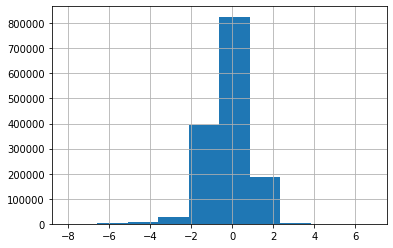

In [43]:
df.model_llr.hist()

In [44]:
spearmanr(df.AC, df.model_llr)

SpearmanrResult(correlation=0.039096699899264564, pvalue=0.0)

In [45]:
df["Status"] = "Neither"
df.loc[df.AC <= 10, "Status"] = "Rare"
df.loc[df.AC > 100, "Status"] = "Common"
df.Status.value_counts()

Rare       887015
Neither    343496
Common     213550
Name: Status, dtype: int64

In [46]:
mannwhitneyu(df.loc[df.Status=="Rare", "model_llr"], df.loc[df.Status=="Common", "model_llr"], alternative="less")

MannwhitneyuResult(statistic=88989037986.0, pvalue=0.0)

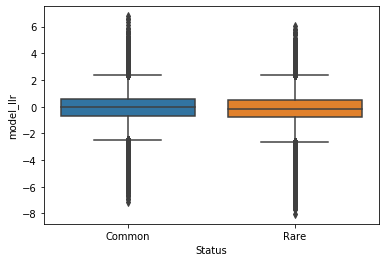

In [47]:
sns.boxplot(data=df[df.Status.isin(["Rare", "Common"])], x="Status", y="model_llr")

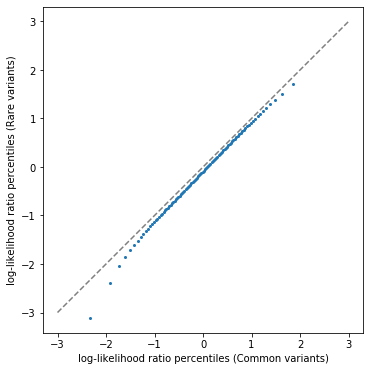

In [48]:
plt.figure(figsize=(6, 6))
plt.scatter(
    np.percentile(df[df.Status=="Common"].model_llr, np.arange(1, 100)),
    np.percentile(df[df.Status=="Rare"].model_llr, np.arange(1, 100)),
    s=4,
)
plt.xlabel("log-likelihood ratio percentiles (Common variants)")
plt.ylabel("log-likelihood ratio percentiles (Rare variants)")
plt.plot([-3, 3], [-3, 3], "--", color="gray")
plt.gca().set_aspect('equal', 'box')

In [49]:
df.consequence.value_counts()

intergenic_variant                                                                                                478418
intron_variant                                                                                                    237750
missense_variant                                                                                                  187997
synonymous_variant                                                                                                141138
3_prime_UTR_variant                                                                                                63951
                                                                                                                   ...  
downstream_gene_variant,non_coding_transcript_exon_variant,stop_retained_variant,synonymous_variant                    1
intron_variant,splice_acceptor_variant,splice_region_variant,upstream_gene_variant                                     1
intron_variant,non_coding_transc

In [50]:
df.consequence.value_counts().head(20)

intergenic_variant                               478418
intron_variant                                   237750
missense_variant                                 187997
synonymous_variant                               141138
3_prime_UTR_variant                               63951
upstream_gene_variant                             58486
5_prime_UTR_variant                               48786
downstream_gene_variant                           47564
3_prime_UTR_variant,downstream_gene_variant       20348
intron_variant,splice_region_variant              19555
5_prime_UTR_variant,intron_variant                12675
5_prime_UTR_variant,upstream_gene_variant         10623
non_coding_transcript_exon_variant                 9746
downstream_gene_variant,upstream_gene_variant      9600
3_prime_UTR_variant,intron_variant                 8428
3_prime_UTR_variant,missense_variant               5823
3_prime_UTR_variant,upstream_gene_variant          4890
3_prime_UTR_variant,synonymous_variant          

In [51]:
(df.consequence=="stop_gained").sum()

3478

In [57]:
df2 = df.groupby("consequence").agg({"model_llr": "mean", "pos": "size"}).rename(columns={"model_llr": "mean_model_llr", "pos": "counts"})
df2 = df2[df2.counts >= 3000].sort_values("mean_model_llr")
df2

,mean_model_llr,counts
consequence,,
stop_gained,-0.910304,3478
5_prime_UTR_variant,-0.283451,48786
"5_prime_UTR_variant,upstream_gene_variant",-0.266545,10623
"5_prime_UTR_variant,downstream_gene_variant",-0.263992,3355
"5_prime_UTR_variant,intron_variant",-0.213977,12675
intergenic_variant,-0.197423,478418
"downstream_gene_variant,upstream_gene_variant",-0.190294,9600
"5_prime_UTR_variant,missense_variant",-0.187545,3610
"intron_variant,splice_region_variant",-0.187406,19555


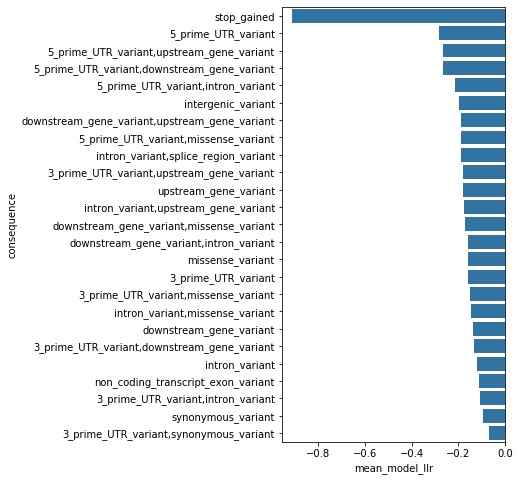

In [60]:
plt.figure(figsize=(4,8))
ax = sns.barplot(data=df2.reset_index(), y="consequence", x="mean_model_llr", color="C0")
#ax.set_xticklabels(ax.get_xticklabels(),rotation=90);
plt.savefig("llr_by_consequence.pdf", bbox_inches='tight')

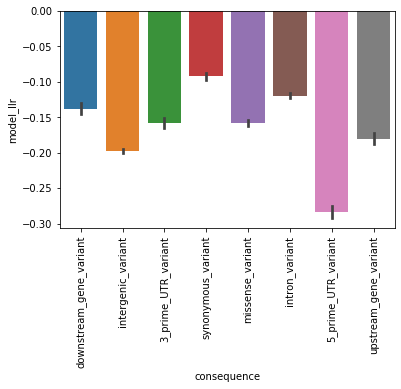

In [53]:
ax = sns.barplot(data=df[df.consequence.isin(df.consequence.value_counts().head(8).index)], x="consequence", y="model_llr")
ax.set_xticklabels(ax.get_xticklabels(),rotation=90);